## Notebook setup

In [42]:
sys.path.append('../src')

import pandas as pd
import os
from db.connection import ConexionBD
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

%matplotlib inline

In [2]:
# Set variables for DB Connection
os.environ['POSTGRES_USER'] = 'test_user'
os.environ['POSTGRES_PASSWORD'] = '1234'
os.environ['DB_HOST'] = 'localhost'
os.environ['DB_PORT'] = '5432'
os.environ['DB_NAME'] = 'test'

In [3]:
conn = ConexionBD.obtener_conexion()

## Expenses anylisis

**Data setup**

In [4]:
query = """
    SELECT fecha_valor, importe, saldo
    FROM bancapp.movimientos_mview
    """

results =  conn.execute(query).fetchall()
df = pd.DataFrame(results)
                 
# Convierte múltiples columnas a numérico; si encuentra basura, pone NaN
cols_numericas = ['importe', 'saldo']
df[cols_numericas] = df[cols_numericas].apply(pd.to_numeric, errors='coerce')

# Convierte a fecha
df['fecha_valor'] = pd.to_datetime(df['fecha_valor'])
df['mes_valor'] = df["fecha_valor"].dt.month
df['anio_valor'] = df["fecha_valor"].dt.year

**Expenses dataframe**

In [5]:
df_gastos = df[df.importe<0][["fecha_valor","mes_valor","anio_valor", "importe"]]
df_gastos["importe"] = df_gastos["importe"].apply(abs)

In [6]:
df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2010 entries, 0 to 2323
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fecha_valor  2010 non-null   datetime64[ns]
 1   mes_valor    2010 non-null   int32         
 2   anio_valor   2010 non-null   int32         
 3   importe      2010 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int32(2)
memory usage: 62.8 KB


In [7]:
df_gastos.importe.describe([.25, .5, .75, .90, .95, .99])

count    2010.000000
mean       74.148184
std       242.325766
min         0.490000
25%        10.402500
50%        27.240000
75%        72.127500
90%       200.000000
95%       301.000000
99%       495.670000
max      9000.000000
Name: importe, dtype: float64

**Outliers**

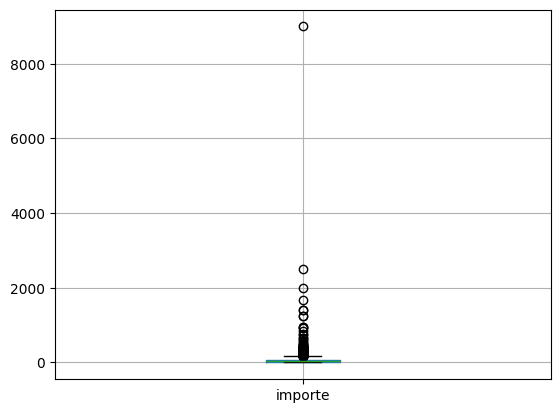

In [8]:
df_gastos.boxplot(column="importe");

In [9]:
IQR = df_gastos.importe.quantile(0.75) - df_gastos.importe.quantile(0.25)

higher_fence = df_gastos.importe.quantile(0.75) + (IQR * 1.5)

print("Valor límite de gastos para atípicos: ", higher_fence)

Valor límite de gastos para atípicos:  164.71499999999997


Remove outliers

In [10]:
df_gastos_nooutliers = df_gastos[df_gastos.importe < higher_fence]

In [11]:
df_gastos_nooutliers.importe.describe([.25, .5, .75, .90, .95, .99])

count    1767.000000
mean       34.122037
std        33.355227
min         0.490000
25%         9.655000
50%        22.000000
75%        49.900000
90%        80.850000
95%       102.900000
99%       145.966800
max       163.000000
Name: importe, dtype: float64

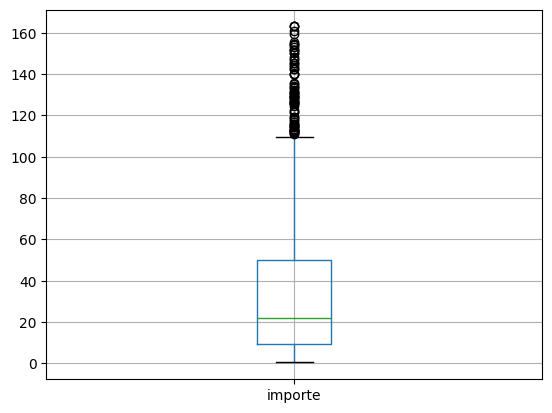

In [12]:
df_gastos_nooutliers.boxplot(column="importe");

**Expenses by year (with trend)**

In [91]:
df_gastos_nooutliers_by_month = df_gastos_nooutliers.groupby(by=["anio_valor","mes_valor"]).agg(gasto_total=("importe","sum"))

Tendencia

In [92]:
from sklearn import linear_model

reg = linear_model.LinearRegression()

X = np.arange(0,len(df_gastos_nooutliers_by_month["gasto_total"])).reshape(-1, 1)
y = df_gastos_nooutliers_by_month["gasto_total"].values

tendencia = reg.fit(X,y).predict(X)


Plot

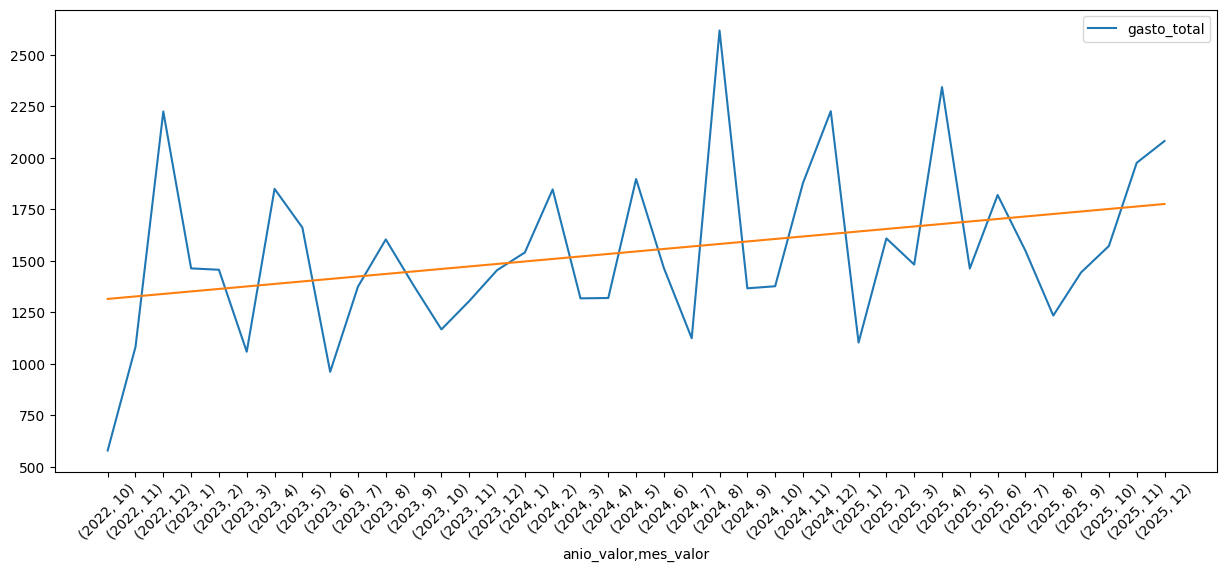

In [98]:
df_gastos_nooutliers_by_month.plot.line(rot=45, figsize=(15,6));
plt.plot(X, tendencia)
plt.xticks(range(len(df_gastos_nooutliers_by_month.gasto_total)),df_gastos_nooutliers_by_month.index, rotation=45)
plt.show();

In [111]:
print(f"Tendencia - min:{float(min(tendencia)):.0f} max:{float(max(tendencia)):.0f}")

Tendencia - min:1316 max:1776
